In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import date
import shap

os.chdir("../")
base_path = os.getcwd()

from machine_learning.mlMethods import *
from machine_learning.machine_learning_ocorrencia_doenca import *
from machine_learning.measuringResults import *

## Applying ML

In [3]:
columns_filtered = ['nome_bairro', 'mes', 'temp_solo', 'precipitacao', 'qtd_cnes',
                    'IDH', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12']

categorical_columns = ['nome_bairro', 'mes']

columns_filtered_categorical = ['nome_bairro_Realengo',  'nome_bairro_Santa Cruz',
                                'nome_bairro_Bangu', 'nome_bairro_Campo Grande',
                                'nome_bairro_Senador Camará', "mes_1"]

df_treino, df_teste, df_previsao, regressor = main(columns_filtered, categorical_columns,
                                                   columns_filtered_categorical)

Boolean Series key will be reindexed to match DataFrame index.


####################### randomforest ###################
test mean r2: 0.47
test std r2: 0.12
test mean mean_squared_error: -10.46
test std mean_squared_error: 8.17
test mean mean_absolute_error: -1.48
test std mean_absolute_error: 0.48


## Preparing data to SHAP Value - Tree Explainer

In [6]:
# regressor = read_from_pickle('regressor_v1')

df_treino_X = df_treino[columns_filtered]
df_teste_X = df_teste[columns_filtered]

# Categorical values
if not categorical_columns == []:
    df_treino_X = pd.get_dummies(df_treino_X, columns=categorical_columns)
    df_teste_X = pd.get_dummies(df_teste_X, columns=categorical_columns)
    
new_columns_features = [a for a in columns_filtered if a not in categorical_columns]

df_treino_X = df_treino_X[new_columns_features+columns_filtered_categorical]
df_teste_X = df_teste_X[new_columns_features+columns_filtered_categorical]

columns_filtered_ordered, index_time_cols = get_indices_columns_time(df_treino_X.columns)
df_treino_X = df_treino_X[columns_filtered_ordered]
df_teste_X = df_teste_X[columns_filtered_ordered]

# df_teste.drop(columns=['dengue_diagnosis_previsto', 'diff'], inplace=True)
df_teste['dengue_diagnosis_previsto'] = regressor.predict(df_teste_X)
df_teste['diff'] = df_teste[['dengue_diagnosis', 'dengue_diagnosis_previsto']].apply(
    lambda x: abs(x[0] - x[1]), axis=1)

## Applying Tree Explainer

In [7]:
# # Applying to train data
# explainer_train = shap.TreeExplainer(regressor, df_treino_X,
#                                feature_perturbation="interventional")
# shap_values_train = explainer_train.shap_values(df_treino_X, check_additivity=False)

# Applying to test data
explainer_test = shap.TreeExplainer(regressor, df_teste_X,
                               feature_perturbation="interventional")
shap_values_test = explainer_test.shap_values(df_teste_X, check_additivity=False)

# explainer_test = read_from_pickle('tree_explainer_test_v1')
# shap_values_test = read_from_pickle('shap_base_teste_v1')

Passing 1920 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 1917/1920 [11:54<00:01]        

## Analysing Worst Cases

Valor real: 49.0
Valor previsto: 8.6


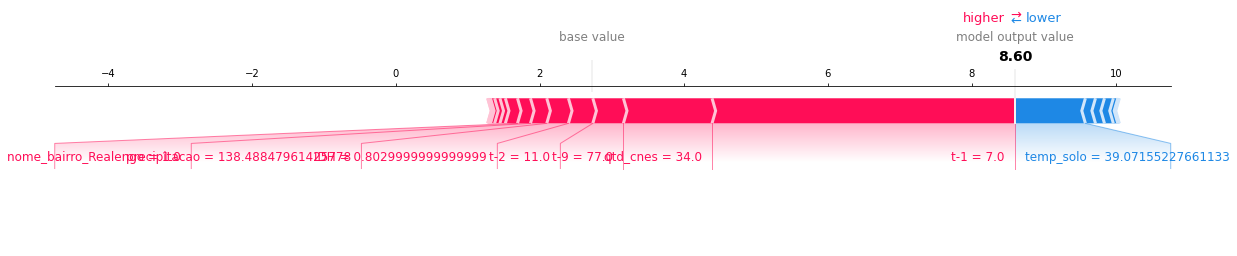

Unnamed: 0                                           11628
Unnamed: 0.1                                         17388
cod_bairro                                    330455705097
nome_bairro                                       Realengo
ano                                                   2017
mes                                                      1
chave                                    33045570509720171
qtd_cnes                                                34
qtd_serv_atencao_basica                                 13
qtd_serv_ACS_program                                     0
qtd_serv_prenatal                                       15
qtd_serv_neonatal                                        2
qtd_serv_plano_familia_STD                               2
qtd_afiliacao_sus                                       31
temp_solo                                          39.0716
precipitacao                                       138.488
Esperança de vida ao nascer (em anos)                69.

In [8]:
list_diff = list(df_teste["diff"])
list_diff_orde = list(df_teste["diff"])
list_diff_orde.sort(reverse=True)

i = 0

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

Valor real: 49.0
Valor previsto: 10.14


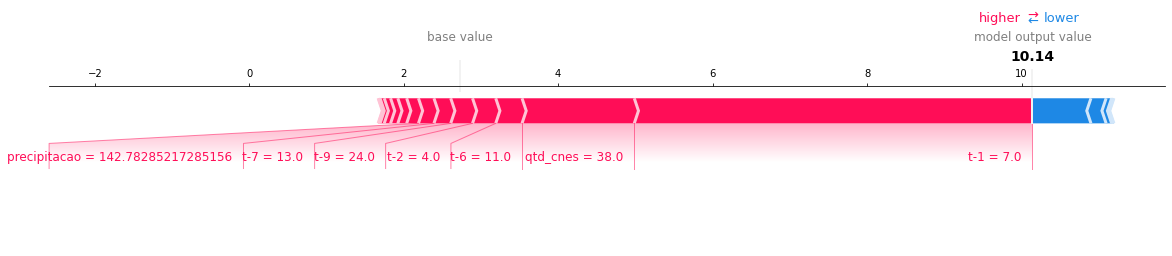

Unnamed: 0                                           12828
Unnamed: 0.1                                         19188
cod_bairro                                    330455705107
nome_bairro                                     Santa Cruz
ano                                                   2017
mes                                                      1
chave                                    33045570510720171
qtd_cnes                                                38
qtd_serv_atencao_basica                                 12
qtd_serv_ACS_program                                     1
qtd_serv_prenatal                                       18
qtd_serv_neonatal                                        0
qtd_serv_plano_familia_STD                               2
qtd_afiliacao_sus                                       30
temp_solo                                          38.1476
precipitacao                                       142.783
Esperança de vida ao nascer (em anos)                65.

In [9]:
i = 1

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

Valor real: 23.0
Valor previsto: 61.8


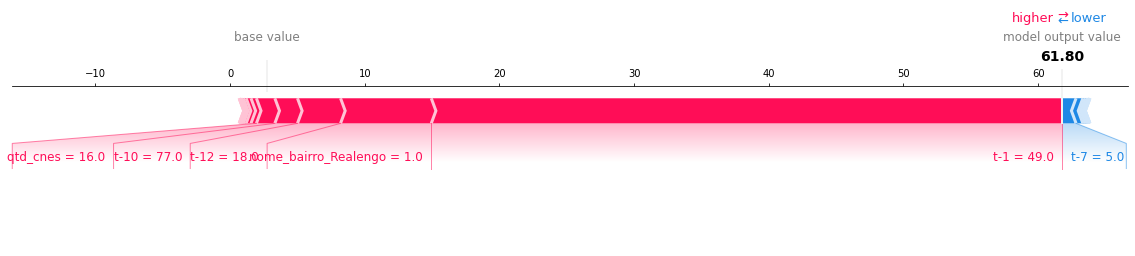

Unnamed: 0                                           11629
Unnamed: 0.1                                         17389
cod_bairro                                    330455705097
nome_bairro                                       Realengo
ano                                                   2017
mes                                                      2
chave                                    33045570509720172
qtd_cnes                                                16
qtd_serv_atencao_basica                                  6
qtd_serv_ACS_program                                     0
qtd_serv_prenatal                                        7
qtd_serv_neonatal                                        1
qtd_serv_plano_familia_STD                               1
qtd_afiliacao_sus                                       15
temp_solo                                          40.7479
precipitacao                                       131.773
Esperança de vida ao nascer (em anos)                69.

In [10]:
i = 2

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

Valor real: 40.0
Valor previsto: 12.78


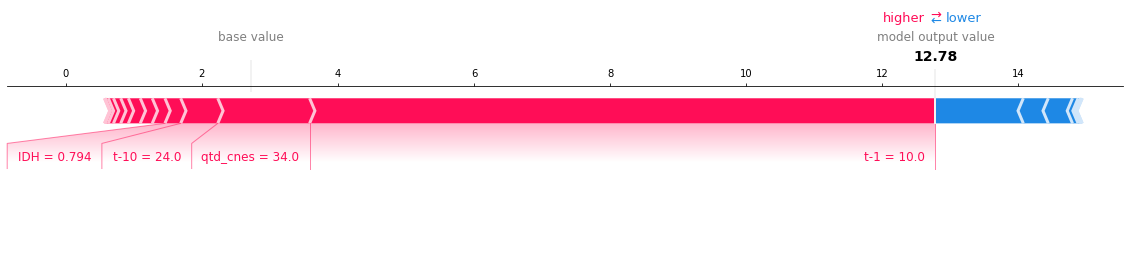

Unnamed: 0                                           11868
Unnamed: 0.1                                         17748
cod_bairro                                    330455705099
nome_bairro                                          Bangu
ano                                                   2017
mes                                                      1
chave                                    33045570509920171
qtd_cnes                                                34
qtd_serv_atencao_basica                                 10
qtd_serv_ACS_program                                     3
qtd_serv_prenatal                                       14
qtd_serv_neonatal                                        0
qtd_serv_plano_familia_STD                               6
qtd_afiliacao_sus                                       26
temp_solo                                          39.5113
precipitacao                                       132.928
Esperança de vida ao nascer (em anos)                69.

In [11]:
i = 3

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

Valor real: 68.0
Valor previsto: 41.4


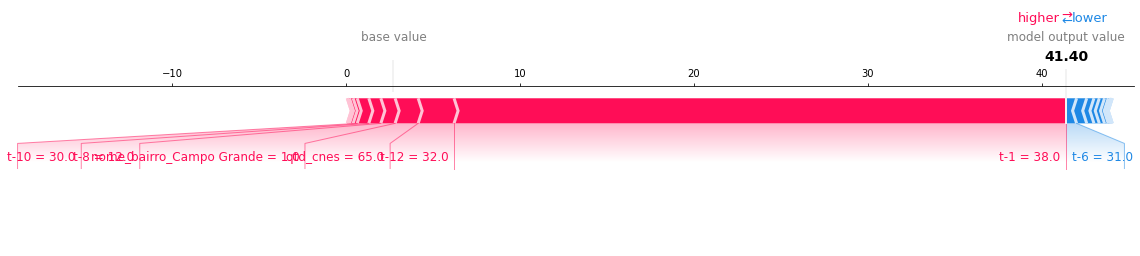

Unnamed: 0                                           12228
Unnamed: 0.1                                         18288
cod_bairro                                    330455705102
nome_bairro                                   Campo Grande
ano                                                   2017
mes                                                      1
chave                                    33045570510220171
qtd_cnes                                                65
qtd_serv_atencao_basica                                 11
qtd_serv_ACS_program                                     0
qtd_serv_prenatal                                       17
qtd_serv_neonatal                                        0
qtd_serv_plano_familia_STD                               4
qtd_afiliacao_sus                                       38
temp_solo                                          38.3409
precipitacao                                       146.821
Esperança de vida ao nascer (em anos)                 69

In [12]:
i = 4

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

Valor real: 18.0
Valor previsto: 39.92


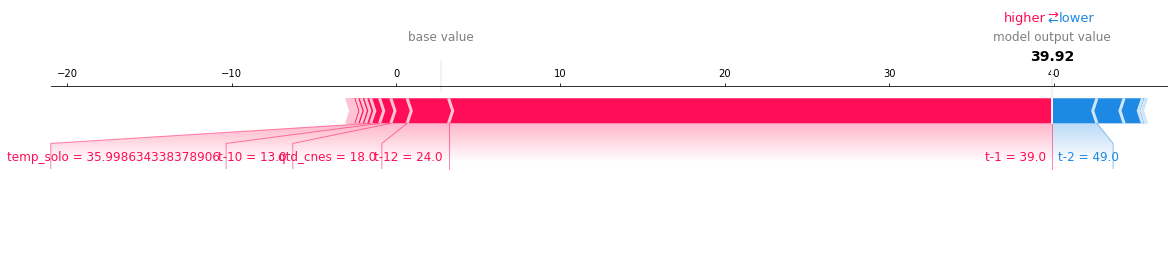

Unnamed: 0                                           12831
Unnamed: 0.1                                         19191
cod_bairro                                    330455705107
nome_bairro                                     Santa Cruz
ano                                                   2017
mes                                                      4
chave                                    33045570510720174
qtd_cnes                                                18
qtd_serv_atencao_basica                                  6
qtd_serv_ACS_program                                     0
qtd_serv_prenatal                                        9
qtd_serv_neonatal                                        0
qtd_serv_plano_familia_STD                               1
qtd_afiliacao_sus                                       15
temp_solo                                          35.9986
precipitacao                                       65.4311
Esperança de vida ao nascer (em anos)                65.

In [13]:
i = 5

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

## Using force_plot

In [ ]:
i = -100

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

In [ ]:
i = -200

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

In [ ]:
i = -300

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

In [ ]:
i = -3

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

In [ ]:
i = -4

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

In [ ]:
i = -5

print("Valor real: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis')]))
print("Valor previsto: {}".format(df_teste.iloc[list_diff.index(list_diff_orde[i]),
                                             list(df_teste.columns).index('dengue_diagnosis_previsto')]))

shap.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[i]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[i]), :],
                                                            matplotlib=True)

df_teste.iloc[list_diff.index(list_diff_orde[i]),:]

In [14]:
shap.initjs()

shap_values_test.force_plot(explainer_test.expected_value, shap_values_test[list_diff.index(list_diff_orde[0]), :],
                                                            df_teste_X.iloc[list_diff.index(list_diff_orde[0]), :],
                                                            matplotlib=True)

AttributeError: 'numpy.ndarray' object has no attribute 'force_plot'

In [ ]:
df_teste.iloc[list_diff.index(list_diff_orde[0]),
                            list(df_teste.columns).index('dengue_diagnosis_previsto')]

In [5]:
df_teste.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'cod_bairro', 'nome_bairro', 'ano', 'mes',
       'chave', 'qtd_cnes', 'qtd_serv_atencao_basica', 'qtd_serv_ACS_program',
       'qtd_serv_prenatal', 'qtd_serv_neonatal', 'qtd_serv_plano_familia_STD',
       'qtd_afiliacao_sus', 'temp_solo', 'precipitacao',
       'Esperança de vida ao nascer (em anos)',
       'Taxa de alfabetização de adultos (%)',
       'Taxa bruta de frequência escolar (%)',
       'Renda per capita (em R$ de 2000)', 'IDH-L', 'IDH-E', 'IDH-R', 'IDH',
       'tuberculosis_diagnosis', 'syphilis_adquirida_diagnosis',
       'syphilis_congenita_diagnosis', 'syphilis_gestante_diagnosis',
       'influenza_diagnosis', 'dengue_diagnosis', 't-1', 't-2', 't-3', 't-4',
       't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 'data',
       'umidade', 'max_vizinhos_t-1', 'media_vizinhos_t-1', 'max_vizinhos_t-3',
       'media_vizinhos_t-3', 'max_vizinhos_t-6', 'media_vizinhos_t-6',
       'temp_hist', 'prec_hist', 'dengue_diagnos